# Extract features from CSLs
After creating and annotating CSLs, features can be extracted from each cell to quantitatively compare molecular intensity differences and spatial re-localisation of proteins in different conditions. 
CAMPA can extract the following features:

- Intensity: per-cluster mean and size features. Needs to be calculated first to set up the adata.
- Co-occurrence: spatial co-occurrence between pairs of clusters at different distances.
- Object stats: number and area of connected components per cluster

The features are saved as an `AnnData` object and can be used to compare molecular abundance within CSLs and spatial co-occurrence of CSLs in different conditions (e.g. perturbations).

Please make sure that you clustered the data and projected the result to the entire example dataset as described in the [Cluster data into CSLs tutorial](cluster.ipynb) before running this tutorial.

In [1]:
import os

from IPython.display import display
import pandas as pd
import anndata as ad

from campa.pl import (
    plot_mean_size,
    plot_object_stats,
    plot_co_occurrence,
    plot_mean_intensity,
    get_intensity_change,
    plot_intensity_change,
    plot_co_occurrence_grid,
)
from campa.tl import Experiment, extract_features, FeatureExtractor
from campa.utils import load_config, init_logging, merged_config
from campa.constants import campa_config

# init logging with level INFO=20, WARNING=30
init_logging(level=30)
# read correct campa_config -- created with setup.ipynb
campa_config.config_fname = "params/campa.ini"
print(campa_config)

Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini
Reading config from params/campa.ini
CAMPAConfig (fname: params/campa.ini)
EXPERIMENT_DIR: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments
BASE_DATA_DIR: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_data/raw
CO_OCC_CHUNK_SIZE: 10000000.0
data_config/nascentrna: /Users/hannah.spitzer/projects/pelkmans/software_new/campa_ana/NascentRNA_constants.py
data_config/testdata: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/tests/_data/TestData_constants.py
data_config/exampledata: /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/params/ExampleData_constants.py



## Extract features
To extract features, the high-level API function [extract_features][] is used.

Extracting co-occurrence scores can take a long time, and it is recommended to use the CLI to run the feature extraction in a script:
```
campa extract_features $CAMPA_DIR/notebooks/params/example_features_params.py
```

To define which features should be extracted, a parameter dictionary is used. All parameters that can be set in this dictionary are documented with the [extract_features][] function. Here, we are going to use an [example feature params](https://github.com/theislab/campa/blob/main/notebooks/params/example_feature_params.py) file that extracts intensity, co-occurrence, and object features (object size, circularity, etc.) from the `test_pre_trained/CondVAE_pert-CC` experiment we clustered in [the clustering tutorial](cluster.ipynb).

[extract_features]: ../api/campa.tl.extract_features.rst

In [2]:
# load parameter dictionary
params = load_config("params/example_feature_params.py")
# just use the first variable_params configuration here
for variable_params in params.variable_feature_params[:1]:
    cur_params = merged_config(params.feature_params, variable_params)
print(cur_params)

{'experiment_dir': 'test_pre_trained/CondVAE_pert-CC', 'cluster_name': 'clustering_res0.2', 'cluster_dir': None, 'cluster_col': 'annotation', 'data_dirs': ['184A1_unperturbed/I09', '184A1_unperturbed/I11', '184A1_meayamycin/I12', '184A1_meayamycin/I20'], 'save_name': 'features_annotation.h5ad', 'force': False, 'features': ['intensity', 'co-occurrence', 'object-stats'], 'co_occurrence_params': {'min': 2.0, 'max': 60.0, 'nsteps': 5, 'logspace': True, 'num_processes': None}, 'object_stats_params': {'features': ['area', 'circularity', 'elongation', 'extent'], 'channels': []}}


Using these parameters, we can now extract the features. The extracted features will be saved to `cur_params['save_name']` in each data directory in `experiment_dir/aggregated/full_data`.

Note that this step will take ~10 minutes to complete. For a faster result, you can turn off the computation of the co-occurrence features by setting `cur_params['features'] = ['intensity', 'object-stats']`

In [3]:
extract_features(cur_params)

Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/full_data/184A1_unperturbed/I09/clustering_res0.2.npy


/Users/hannah.spitzer/projects/pelkmans/software_new/campa/campa/tl/_features.py:433: RuntimeWarning: divide by zero encountered in double_scalars
  features[feature].append(min(4 * np.pi * region.area / region.perimeter ** 2, 1))


Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/full_data/184A1_unperturbed/I11/clustering_res0.2.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/full_data/184A1_meayamycin/I12/clustering_res0.2.npy
Cannot read with memmap:  /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/full_data/184A1_meayamycin/I20/clustering_res0.2.npy


## Explore and plot extracted features

Features are stored in `AnnData` objects with `obs=cells` and `vars=channels`.
Intensity information is stored as layers, co-occurrence scores as `obsm` matrices (`obs x distances` for each cluster-cluster pair),
and object features as matrices in `uns`.

The [FeatureExtractor][] class loads this `AnnData` object and provides convenience functions to access feature information.

[FeatureExtractor]: ../classes/campa.tl.FeatureExtractor.rst

In [4]:
# load features for each data_dir
exp = Experiment.from_dir("test_pre_trained/CondVAE_pert-CC")
extrs = [
    FeatureExtractor.from_adata(
        os.path.join(exp.full_path, "aggregated/full_data", data_dir, "features_annotation.h5ad")
    )
    for data_dir in exp.data_params["data_dirs"]
]

extrs[0].adata

AnnData object with n_obs × n_vars = 12 × 34
    obs: 'mapobject_id', 'plate_name', 'well_name', 'well_pos_y', 'well_pos_x', 'tpoint', 'zplane', 'label', 'is_border', 'mapobject_id_cell', 'plate_name_cell', 'well_name_cell', 'well_pos_y_cell', 'well_pos_x_cell', 'tpoint_cell', 'zplane_cell', 'label_cell', 'is_border_cell', 'is_mitotic', 'is_mitotic_labels', 'is_polynuclei_HeLa', 'is_polynuclei_HeLa_labels', 'is_polynuclei_184A1', 'is_polynuclei_184A1_labels', 'is_SBF2_Sphase_labels', 'is_SBF2_Sphase', 'Heatmap-48', 'cell_cycle', 'description', 'dimensions', 'id', 'cell_type', 'EU', 'duration', 'perturbation', 'secondary_only', 'siRNA', 'perturbation_duration', 'LocalDensity_Nuclei_800', 'TR_factor', 'TR_norm', 'TR', 'TR_factor_DMSO-unperturbed', 'TR_norm_DMSO-unperturbed', 'obj_id_int'
    uns: 'clusters', 'co_occurrence_params', 'object_stats', 'object_stats_params', 'params'
    obsm: 'co_occurrence_Nuclear periphery_Nuclear periphery', 'co_occurrence_Nuclear periphery_Nuclear speckl

The `AnnData` object contains all feature information

In [5]:
extr = extrs[0]
print("AnnData read from", extr.fname)
print(extr.adata)

AnnData read from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/full_data/184A1_unperturbed/I09/features_annotation.h5ad
AnnData object with n_obs × n_vars = 12 × 34
    obs: 'mapobject_id', 'plate_name', 'well_name', 'well_pos_y', 'well_pos_x', 'tpoint', 'zplane', 'label', 'is_border', 'mapobject_id_cell', 'plate_name_cell', 'well_name_cell', 'well_pos_y_cell', 'well_pos_x_cell', 'tpoint_cell', 'zplane_cell', 'label_cell', 'is_border_cell', 'is_mitotic', 'is_mitotic_labels', 'is_polynuclei_HeLa', 'is_polynuclei_HeLa_labels', 'is_polynuclei_184A1', 'is_polynuclei_184A1_labels', 'is_SBF2_Sphase_labels', 'is_SBF2_Sphase', 'Heatmap-48', 'cell_cycle', 'description', 'dimensions', 'id', 'cell_type', 'EU', 'duration', 'perturbation', 'secondary_only', 'siRNA', 'perturbation_duration', 'LocalDensity_Nuclei_800', 'TR_factor', 'TR_norm', 'TR', 'TR_factor_DMSO-unperturbed', 'TR_norm_DMSO-unperturbed', 'obj_id_

### Intensity features
Intensity features are the mean intensity of channels in each cluster (CSL).

Intensity information for each CSL is contained in a separate layer in `FeatureExtractor.adata.layers`. Overall (per cell) intensity information is stored in `FeatureExtractor.adata.X`.
In addition to the mean intensity per CSL, the adata also contains the size of each CSL per cell in `FeatureExtractor.adata.obsm['size']`

In [6]:
# intensity per CSL
print("Intensity per CLS stored in", extr.adata.layers)

# whole cell intensity
print("Whole cell intensity stored in X with shape", extr.adata.X.shape)

# size of CSLs per cell
display(extr.adata.obsm["size"])

Intensity per CLS stored in Layers with keys: intensity_Nuclear periphery, intensity_Nuclear speckles, intensity_Nucleolus, intensity_Nucleoplasm, intensity_PML bodies
Whole cell intensity stored in X with shape (12, 34)


,all,Nuclear periphery,Nuclear speckles,Nucleolus,Nucleoplasm,PML bodies
0,13668,3135,2400.0,2967,4830,336
1,14816,3307,2901.0,3375,4735,498
2,13048,2589,2724.0,2573,4254,908
3,13478,2244,2074.0,3097,5513,550
4,22785,7678,4225.0,5307,5046,529
5,6876,882,40.0,51,5714,189
6,10961,2694,1710.0,2055,4281,221
7,10340,1692,1242.0,2366,4802,238
8,9010,842,0.0,784,7217,167
9,14668,4609,2558.0,3076,4072,353


It is possible to export the intensity information in one csv file using [FeatureExtractor.extract_intensity_csv][]. 
The resulting csv file contains the intensity per CSL for each channel as columns, with CSLs stacked on top of each other, 
as well as additionally defined columns.
This saves a csv file in `experiment_dir/aggregated/full_data/data_dir/export`.

[FeatureExtractor.extract_intensity_csv]: ../classes/campa.tl.FeatureExtractor.extract_intensity_csv.rst

In [7]:
for extr in extrs:
    extr.extract_intensity_csv(obs=["well_name", "perturbation_duration", "TR"])

In [8]:
extr = extrs[0]
# check if results are stored
save_dir = os.path.join(os.path.dirname(extr.fname), "export")
print("csv exported to", save_dir)
print([n for n in os.listdir(save_dir) if "intensity" in n])

display(pd.read_csv(os.path.join(save_dir, "intensity_features_annotation.csv"), index_col=0))

csv exported to /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/full_data/184A1_unperturbed/I09/export
['intensity_features_annotation.csv']


,00_DAPI,01_CDK9_pT186,01_PABPC1,02_CDK7,03_CDK9,03_RPS6,05_GTF2B,05_Sm,07_H2B,07_POLR2A,...,20_ALYREF,20_SP100,21_COIL,21_NCL,size,cluster,mapobject_id,well_name,perturbation_duration,TR
0,0.426456,0.200636,0.189683,0.285610,0.194893,0.322412,0.370435,0.438719,0.699710,0.256938,...,0.491745,0.061097,0.307471,0.231150,13668.0,all,205776,I09,normal,357.672008
1,0.385045,0.303460,0.430362,0.394213,0.315713,0.492580,0.514705,0.501521,0.588800,0.289786,...,0.479771,0.115659,0.310698,0.313422,14816.0,all,205790,I09,normal,428.364268
2,0.425817,0.328280,0.540552,0.513392,0.304854,0.516456,0.334377,0.502581,0.482021,0.334022,...,0.354707,0.217474,0.366388,0.209569,13048.0,all,248082,I09,normal,250.488581
3,0.620234,0.341173,0.306454,0.377553,0.308710,0.439165,0.439782,0.425142,0.505664,0.390137,...,0.394905,0.126015,0.281631,0.222290,13478.0,all,248102,I09,normal,515.735421
4,0.530736,0.250201,0.268805,0.350668,0.187760,0.333003,0.335777,0.327454,0.364005,0.292015,...,0.272732,0.077636,0.237169,0.176783,22785.0,all,259784,I09,normal,348.150713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.533823,0.411840,0.278488,0.579994,0.468104,0.406194,0.630846,0.577590,0.684052,0.545469,...,0.604945,2.356290,0.418481,0.227081,238.0,PML bodies,359378,I09,normal,367.904255
68,0.761924,0.323549,0.408858,0.609761,0.512075,0.468117,0.709169,0.458337,0.689126,0.380075,...,0.577512,0.354161,0.505683,0.294035,167.0,PML bodies,359393,I09,normal,513.668590
69,0.447101,0.169428,0.121844,0.338446,0.231881,0.208053,0.339818,0.419704,0.577305,0.238688,...,0.534976,2.071667,0.336830,0.085756,353.0,PML bodies,366493,I09,normal,330.847832
70,0.445292,0.758552,0.272543,0.829019,0.648379,0.483718,0.792596,0.743350,0.619481,0.806977,...,0.669901,1.793681,0.611280,0.217256,341.0,PML bodies,383341,I09,normal,388.012319


We can compare CSL intensities across discrete conditions using a dot plot.

For this, we first combine all intensity information in one adata, adding one observation per CSL, using [FeatureExtractor.get_intensity_adata][].

[FeatureExtractor.get_intensity_adata]: ../classes/campa.tl.FeatureExtractor.get_intensity_adata.rst

In [9]:
# get combined adata for dotplots
adatas = [extr.get_intensity_adata() for extr in extrs]
adata_intensity = ad.concat(adatas, index_unique="-")

adata_intensity

AnnData object with n_obs × n_vars = 276 × 34
    obs: 'mapobject_id', 'plate_name', 'well_name', 'well_pos_y', 'well_pos_x', 'tpoint', 'zplane', 'label', 'is_border', 'mapobject_id_cell', 'plate_name_cell', 'well_name_cell', 'well_pos_y_cell', 'well_pos_x_cell', 'tpoint_cell', 'zplane_cell', 'label_cell', 'is_border_cell', 'is_mitotic', 'is_mitotic_labels', 'is_polynuclei_HeLa', 'is_polynuclei_HeLa_labels', 'is_polynuclei_184A1', 'is_polynuclei_184A1_labels', 'is_SBF2_Sphase_labels', 'is_SBF2_Sphase', 'Heatmap-48', 'cell_cycle', 'description', 'dimensions', 'id', 'cell_type', 'EU', 'duration', 'perturbation', 'secondary_only', 'siRNA', 'perturbation_duration', 'LocalDensity_Nuclei_800', 'TR', 'obj_id_int', 'size', 'cluster'

`adata_intensity` contains cell-CSL pairs as observations and channels as columns

In [10]:
print(adata_intensity.var_names)
print(adata_intensity.obs[["mapobject_id", "cluster"]])

Index(['00_DAPI', '01_CDK9_pT186', '01_PABPC1', '02_CDK7', '03_CDK9',
       '03_RPS6', '05_GTF2B', '05_Sm', '07_H2B', '07_POLR2A', '07_SETD1A',
       '08_H3K4me3', '09_CCNT1', '09_SRRM2', '10_H3K27ac', '10_POL2RA_pS2',
       '11_KPNA2_MAX', '11_PML', '12_RB1_pS807_S811', '12_YAP1', '13_PABPN1',
       '13_POL2RA_pS5', '14_PCNA', '15_SON', '15_U2SNRNPB', '16_H3',
       '17_HDAC3', '17_SRSF2', '18_NONO', '19_KPNA1_MAX', '20_ALYREF',
       '20_SP100', '21_COIL', '21_NCL'],
      dtype='object')
               mapobject_id     cluster
0-all-0              205776         all
1-all-0              205790         all
2-all-0              248082         all
3-all-0              248102         all
4-all-0              259784         all
...                     ...         ...
4-PML bodies-3       231218  PML bodies
5-PML bodies-3       270030  PML bodies
6-PML bodies-3       276005  PML bodies
7-PML bodies-3       287615  PML bodies
8-PML bodies-3       294517  PML bodies

[276 rows x 2 col

Using this combined adata, we can plot the mean intensity of each channel in each CSL 
and the size of each CSL in the unperturbed cells using [plot_mean_intensity][] and [plot_mean_size][]

[plot_mean_intensity]: ../api/campa.pl.plot_mean_intensity.rst
[plot_mean_size]: ../api/campa.pl.plot_mean_size.rst

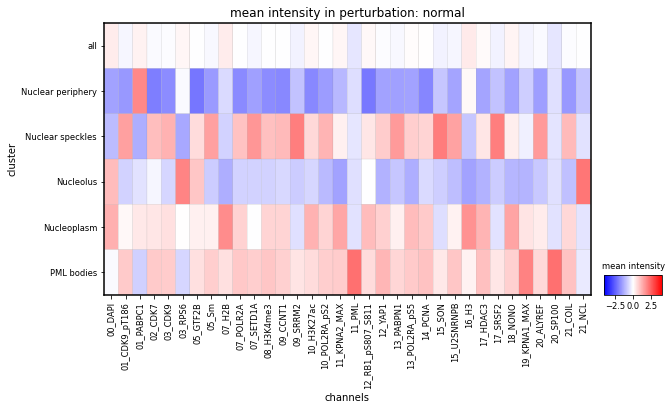

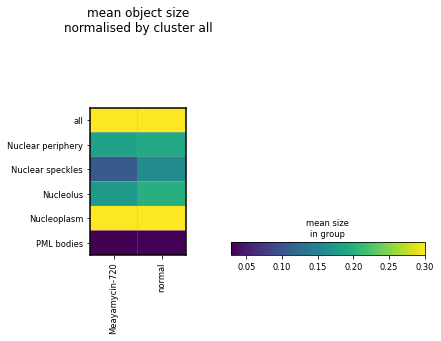

In [11]:
plot_mean_intensity(
    adata_intensity,
    groupby="cluster",
    limit_to_groups={"perturbation": "normal"},
    dendrogram=False,
    layer=None,
    standard_scale="var",
    cmap="bwr",
    vmin=-4,
    vmax=4,
)
plot_mean_size(
    adata_intensity,
    groupby_row="cluster",
    groupby_col="perturbation_duration",
    normby_row="all",
    vmax=0.3,
)

Now, let us visualise the log2fold change in intensity in the Meayamycin perturbation compared to unperturbed cells with [plot_intensity_change].
This plots a dot plot of clusters by channels. The colour of each dot is the log2fold change in intensity compared to unperturbed cells. 
The size of the dots indicated the p-value. Small dots are non-significant intensity changes, large dots are significant (`p > alpha`). 
For the sake of speed, here, p-values are determined using a t-test, for more accurate p-values, please use `pval='mixed_model'`, which will include well as random effect.

The first plot shows the log2fold change, and the second plot the relative log2fold change per CSL, obtained by dividing the values by the "all" column (`norm_by_group='all'`)

[plot_intensity_change]: ../api/campa.pl.plot_intensity_change.rst

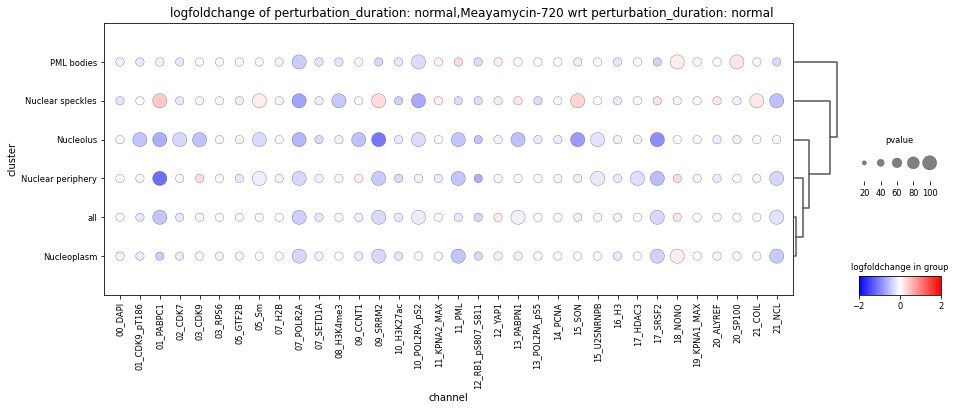

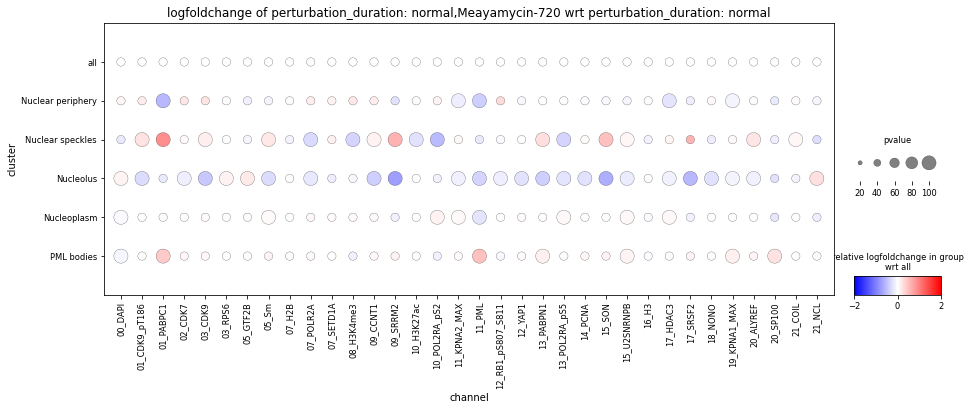

In [12]:
res = get_intensity_change(
    adata_intensity,
    groupby="cluster",
    reference_group="perturbation_duration",
    reference=["normal"],
    limit_to_groups={"perturbation_duration": ["normal", "Meayamycin-720"]},
    color="logfoldchange",
    size="pval",
    pval="ttest",
)
plot_intensity_change(**res, adjust_height=True, figsize=(15, 5), vmin=-2, vmax=2, dendrogram=True)

res = get_intensity_change(
    adata_intensity,
    groupby="cluster",
    reference_group="perturbation_duration",
    reference=["normal"],
    limit_to_groups={"perturbation_duration": ["normal", "Meayamycin-720"]},
    color="logfoldchange",
    size="pval",
    pval="ttest",
    norm_by_group="all",
)
plot_intensity_change(**res, adjust_height=True, figsize=(15, 5), vmin=-2, vmax=2)

### Co-occurrence scores
Co-occurrence scores are calculated for each cluster-cluster pair.
They are stored in `adata.obsm['co_occurrence_{cluster1}_{cluster2}']` as a `n cells x distances` matrix.
The distances used can be found in `adata.uns['co_occurrence_params']`.

In [13]:
extr = extrs[0]
display(extr.adata.obsm["co_occurrence_Nuclear periphery_Nuclear speckles"])

print(extr.adata.uns["co_occurrence_params"])

,0,1,2,3
0,0.109122,0.372870,0.999665,1.006782
1,0.160842,0.500217,1.004321,1.100050
2,0.018774,0.158253,0.902577,1.031636
3,0.067989,0.391648,0.929486,1.147010
4,0.191372,0.441341,0.957172,1.015972
5,0.000000,0.000000,0.377774,1.399852
6,0.236497,0.735880,1.082513,1.014016
7,0.110818,0.438028,1.024439,0.974713
8,0.000000,0.000000,0.000000,0.000000
9,0.293309,0.635853,1.025849,1.016330


{'interval': array([ 2.       ,  4.6806946, 10.954452 , 25.63722  , 60.       ],
      dtype=float32)}


It is possible to export the co-occurrence information in one csv file for each CSL-CSL pair using [FeatureExtractor.extract_co_occurrence_csv][]. 
The resulting csv file contains the co-occurrence scores for each distance interval as columns and cells as rows, 
as well as additionally defined columns.
This saves one csv file per CSL-CSL pair in `experiment_dir/aggregated/full_data/data_dir/export`.

[FeatureExtractor.extract_intensity_csv]: ../classes/campa.tl.FeatureExtractor.extract_co_occurrence_csv.rst

In [27]:
for extr in extrs:
    extr.extract_co_occurrence_csv(obs=["well_name", "perturbation_duration", "TR"])

In [17]:
extr = extrs[0]
# check if results are stored
save_dir = os.path.join(os.path.dirname(extr.fname), "export")
print("csv exported to", save_dir)
print([n for n in os.listdir(save_dir) if "co_occurrence" in n])

display(
    pd.read_csv(
        os.path.join(save_dir, "co_occurrence_Nucleoplasm_Nuclear periphery_features_annotation.csv"), index_col=0
    )
)

csv exported to /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/full_data/184A1_unperturbed/I09/export
['co_occurrence_Nucleoplasm_Nuclear periphery_features_annotation.csv', 'co_occurrence_PML bodies_Nucleolus_features_annotation.csv', 'co_occurrence_Nucleoplasm_Nuclear speckles_features_annotation.csv', 'co_occurrence_Nucleolus_Nuclear periphery_features_annotation.csv', 'co_occurrence_Nuclear speckles_Nuclear speckles_features_annotation.csv', 'co_occurrence_PML bodies_Nuclear speckles_features_annotation.csv', 'co_occurrence_Nuclear periphery_Nucleoplasm_features_annotation.csv', 'co_occurrence_Nucleoplasm_Nucleolus_features_annotation.csv', 'co_occurrence_Nuclear periphery_Nucleolus_features_annotation.csv', 'co_occurrence_PML bodies_Nucleoplasm_features_annotation.csv', 'co_occurrence_Nuclear periphery_Nuclear speckles_features_annotation.csv', 'co_occurrence_PML bodies_PML bodies_features_annota

,2.00-4.68,4.68-10.95,10.95-25.64,25.64-60.00,mapobject_id,well_name,perturbation_duration,TR
0,0.475486,0.894235,1.069050,0.986245,205776,I09,normal,357.672008
1,0.465827,0.883001,1.206197,1.003887,205790,I09,normal,428.364268
2,0.548555,1.088008,1.271062,0.959119,248082,I09,normal,250.488581
3,0.451115,0.918457,1.204916,1.025856,248102,I09,normal,515.735421
4,0.472663,0.675683,0.844964,0.968250,259784,I09,normal,348.150713
5,0.297208,0.610336,0.861790,1.011677,291041,I09,normal,443.565445
6,0.410463,0.764724,1.027486,1.017950,345908,I09,normal,316.004105
7,0.580884,1.113689,1.118337,0.945136,359378,I09,normal,367.904255
8,0.433213,0.788076,0.973858,0.954435,359393,I09,normal,513.668590
9,0.375730,0.584846,0.852134,0.954800,366493,I09,normal,330.847832


We can plot co-occurrence scores by using [plot_co_occurrence][] or [plot_co_occurrence_grid][].
First, we need to combine all adata objects into one. For this, we can use `AnnData.concat`.

[plot_co_occurrence]: ../api/campa.pl.plot_co_occurrence.rst
[plot_co_occurrence_grid]: ../api/campa.pl.plot_co_occurrence_grid.rst


In [18]:
# get combined adata
adata_co_occ = ad.concat([extr.adata for extr in extrs], index_unique="-", uns_merge="same")

print("co-occurrence scores:", adata_co_occ.obsm)

co-occurrence scores: AxisArrays with keys: co_occurrence_Nuclear periphery_Nuclear periphery, co_occurrence_Nuclear periphery_Nuclear speckles, co_occurrence_Nuclear periphery_Nucleolus, co_occurrence_Nuclear periphery_Nucleoplasm, co_occurrence_Nuclear periphery_PML bodies, co_occurrence_Nuclear speckles_Nuclear periphery, co_occurrence_Nuclear speckles_Nuclear speckles, co_occurrence_Nuclear speckles_Nucleolus, co_occurrence_Nuclear speckles_Nucleoplasm, co_occurrence_Nuclear speckles_PML bodies, co_occurrence_Nucleolus_Nuclear periphery, co_occurrence_Nucleolus_Nuclear speckles, co_occurrence_Nucleolus_Nucleolus, co_occurrence_Nucleolus_Nucleoplasm, co_occurrence_Nucleolus_PML bodies, co_occurrence_Nucleoplasm_Nuclear periphery, co_occurrence_Nucleoplasm_Nuclear speckles, co_occurrence_Nucleoplasm_Nucleolus, co_occurrence_Nucleoplasm_Nucleoplasm, co_occurrence_Nucleoplasm_PML bodies, co_occurrence_PML bodies_Nuclear periphery, co_occurrence_PML bodies_Nuclear speckles, co_occurrenc

With [plot_co_occurrence][] we can plot one cluster-cluster pair. With `condition` we can define the grouping of scores. Each group will be displayed by a separate line on the co-occurrence plot.

The co-occurrence plot shows the calculated co-occurrence scores for each distance interval. Here, we show the mean co-occurrence values and their 95th confidence interval obtained through bootstrapping.

[plot_co_occurrence]: ../api/campa.pl.plot_co_occurrence.rst
[plot_co_occurrence_grid]: ../api/campa.pl.plot_co_occurrence_grid.rst

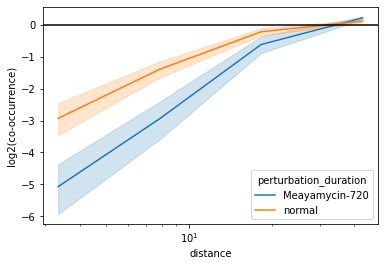

In [19]:
# plot meam co-occ scores
condition = "perturbation_duration"
condition_values = None

# for one cluster-cluster pairing
plot_co_occurrence(adata_co_occ, "Nucleolus", "Nuclear speckles", condition, condition_values, ci=95)

With [plot_co_occurrence_grid][] we can plot an overview of all cluster-cluster pairs.

[plot_co_occurrence_grid]: ../api/campa.pl.plot_co_occurrence_grid.rst

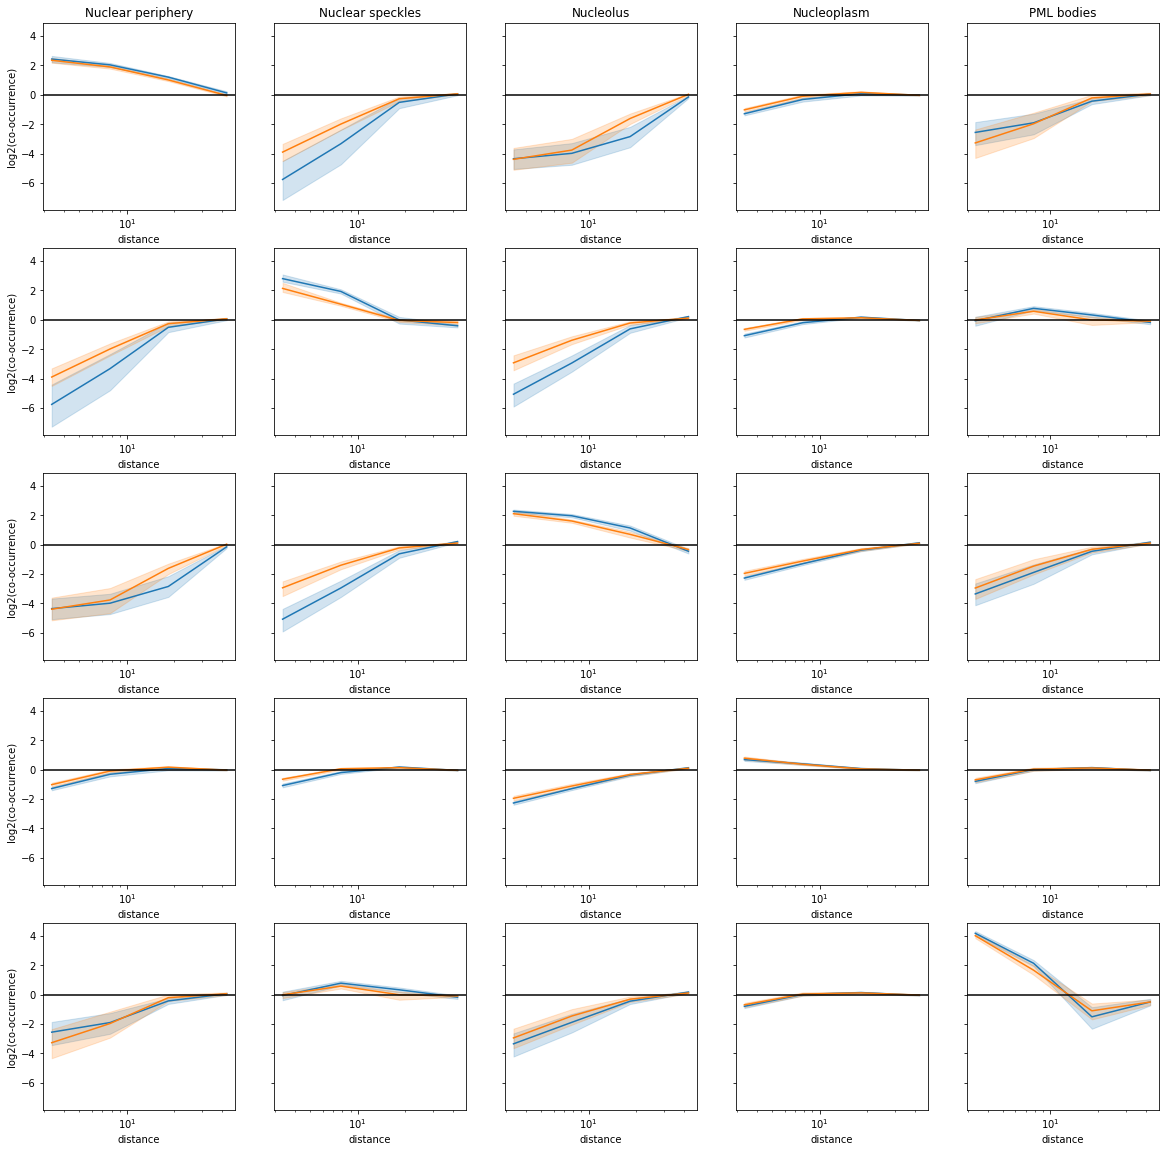

In [20]:
fig, axes = plot_co_occurrence_grid(adata_co_occ, condition, condition_values, legend=False, ci=95, figsize=(20, 20))

### Object statistics
Object statistics are features extracted from connected components per cluster for each cell.
Possible features are `area`, `circlularity`, `elongation`, and `extent` of connected components.
Per component/region features are calculated and stored in `adata.uns['object_stats']`.

In [21]:
display(extrs[0].adata.uns["object_stats"])

,area,circularity,elongation,extent,mapobject_id,clustering
0,2968,0.032425,0.204239,0.154745,205776,Nuclear periphery
1,926,0.607476,0.151208,0.736089,205776,Nucleolus
2,4722,0.026219,0.246185,0.307122,205776,Nucleoplasm
3,26,0.563888,0.710897,0.333333,205776,Nuclear periphery
4,2,1.000000,1.000000,1.000000,205776,Nuclear periphery
...,...,...,...,...,...,...
604,184,0.830349,0.244977,0.601307,383793,Nuclear speckles
605,15,0.929223,0.611781,0.306122,383793,Nuclear periphery
606,26,1.000000,0.231144,0.619048,383793,Nuclear speckles
607,21,0.971038,0.534337,0.583333,383793,PML bodies


To aggregate this information to per-cell level, [FeatureExtractor.get_object_stats][] is used. 
This aggregated the data with the provided aggregation function and stores the result in `adata.obsm['object_stats_agg']`.
In addition, we can filter small areas below `area_threshold` prior to aggregation.

[FeatureExtractor.get_object_stats]: ../classes/campa.tl.FeatureExtractor.get_object_stats.rst


In [22]:
# aggregate object statistics using median
for extr in extrs:
    _ = extr.get_object_stats(area_threshold=10, agg=["median"])

# combined adatas for plotting
adata_object_stats = ad.concat([extr.adata for extr in extrs], index_unique="-", uns_merge="same")

`adata_object_stats` contains aggregated per cell object stats in obsm:

In [23]:
adata_object_stats.obsm["object_stats_agg"]

,area_median|Nuclear periphery,area_median|Nuclear speckles,area_median|Nucleolus,area_median|Nucleoplasm,area_median|PML bodies,circularity_median|Nuclear periphery,circularity_median|Nuclear speckles,circularity_median|Nucleolus,circularity_median|Nucleoplasm,circularity_median|PML bodies,...,extent_median|Nuclear periphery,extent_median|Nuclear speckles,extent_median|Nucleolus,extent_median|Nucleoplasm,extent_median|PML bodies,count|Nuclear periphery,count|Nuclear speckles,count|Nucleolus,count|Nucleoplasm,count|PML bodies
0-0,19.5,111.5,926.0,2406.5,33.0,0.781944,0.820496,0.607476,0.174855,1.000000,...,0.370370,0.620313,0.736089,0.312652,0.745455,4.0,12.0,3.0,2.0,7.0
1-0,3290.0,152.5,426.0,255.5,54.0,0.029923,0.788854,0.662721,0.398234,1.000000,...,0.148278,0.558333,0.650794,0.443347,0.750000,1.0,14.0,3.0,6.0,7.0
2-0,2577.0,107.0,2568.0,58.0,75.5,0.035054,0.709974,0.219800,0.639358,0.960761,...,0.149409,0.501061,0.553926,0.363636,0.754167,1.0,10.0,1.0,5.0,12.0
3-0,1105.5,70.0,3086.0,49.0,41.0,0.163356,0.813656,0.116875,0.515644,0.986452,...,0.113007,0.571429,0.494472,0.341634,0.687500,2.0,15.0,1.0,5.0,13.0
4-0,21.0,171.0,1019.0,82.5,51.5,0.655071,0.743377,0.198580,0.445274,1.000000,...,0.328125,0.629945,0.504206,0.410331,0.747921,15.0,14.0,3.0,16.0,10.0
5-0,96.0,35.0,16.0,5714.0,90.5,0.351757,1.000000,0.834714,0.317625,0.872960,...,0.296296,0.729167,0.536111,0.684639,0.808611,5.0,1.0,2.0,1.0,2.0
6-0,70.0,88.5,1025.0,363.0,35.0,0.662139,0.964564,0.394882,0.273738,1.000000,...,0.338412,0.686065,0.543998,0.407407,0.709722,4.0,16.0,2.0,3.0,6.0
7-0,844.5,42.0,2356.0,4794.0,32.5,0.438933,1.000000,0.219945,0.038190,1.000000,...,0.357965,0.680000,0.426425,0.400970,0.712585,2.0,17.0,1.0,1.0,6.0
8-0,406.5,0.0,57.5,7215.0,76.5,0.275715,0.000000,0.699536,0.109839,0.899725,...,0.365620,0.000000,0.588458,0.609118,0.706575,2.0,0.0,8.0,1.0,2.0
9-0,19.0,105.5,1535.0,694.0,64.0,0.822720,0.871531,0.346780,0.385654,1.000000,...,0.395833,0.629304,0.502111,0.311246,0.715278,7.0,12.0,2.0,4.0,5.0


It is possible to export the object stats in a csv file using [FeatureExtractor.extract_object_stats_csv][]. 
The resulting csv file contains the aggregated object stats matrix from `adata_object_stats.obsm['object_stats_agg']`
as well as additionally defined columns.
This saves one csv file per CSL-CSL pair in `experiment_dir/aggregated/full_data/data_dir/export`.

[FeatureExtractor.extract_object_stats_csv]: ../classes/campa.tl.FeatureExtractor.extract_object_stats_csv.rst

In [24]:
for extr in extrs:
    extr.extract_object_stats_csv(obs=["well_name", "perturbation_duration", "TR"])

In [25]:
extr = extrs[0]
# check if results are stored
save_dir = os.path.join(os.path.dirname(extr.fname), "export")
print("csv exported to", save_dir)
print([n for n in os.listdir(save_dir) if "object_stats" in n])

csv exported to /Users/hannah.spitzer/projects/pelkmans/software_new/campa/notebooks/example_experiments/test_pre_trained/CondVAE_pert-CC/aggregated/full_data/184A1_unperturbed/I09/export
['object_stats_features_annotation.csv']


[plot_object_stats][] can be used to plot a box-plot overview of the object stats. Again, we can define the grouping using `group_key`. 

[plot_object_stats]: ../api/campa.pl.plot_object_stats.rst

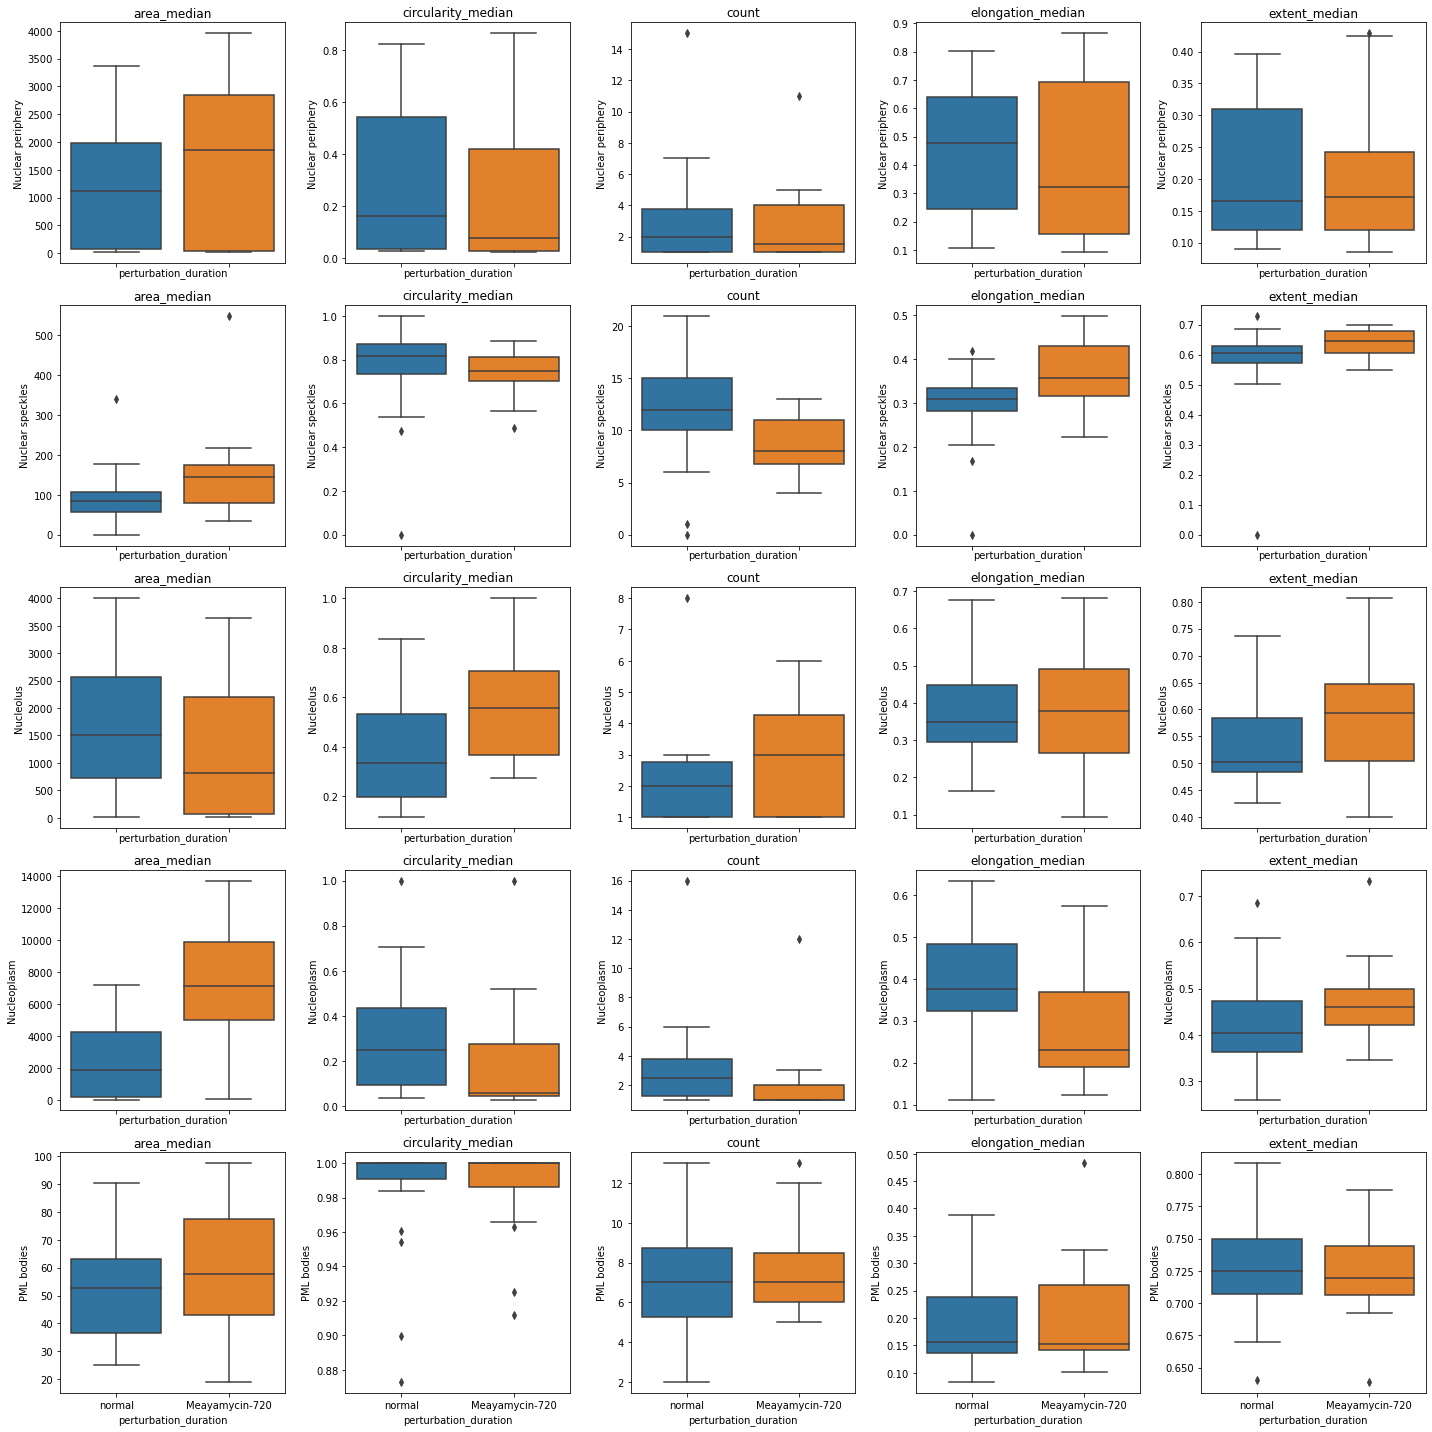

In [26]:
plot_object_stats(adata_object_stats, group_key="perturbation_duration", figsize_mult=(4, 4))